# Nebenüberlegungen zur Visualisierung

## Reddit-API verwenden? 

In [128]:
%matplotlib inline
import praw
import json
import collections
from datetime import datetime
import nltk
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import string
from gensim import corpora, models, similarities
from collections import defaultdict
from pathlib import Path

secret = json.load(open('.secret.json'))
reddit = praw.Reddit(client_id=secret["client_id"], 
                     client_secret= secret["client_secret"], 
                     user_agent='dataviz:v0.1 (by /u/nobody22)')

In [26]:
for submission in reddit.subreddit('learnpython').hot(limit=10):
    print(submission.title)

Ask Anything Monday - Weekly Thread
Software engineering in Python
PyBites Code Challenge 29 - Create a Simple Django App
Getting a traceback error on a beginner's regular expression program
Non-horrible way to parse large text files?
Using RoboBrowser to submit forms
How would I go about creating a bot that tells me if audio is playing in a certain tab?
Need help with multiple processes to grab wiki definitions
How do I send a dictonry to csv with multiple columns?
More Pythonic way to deal with list indices?


<blockquote class="reddit-card" data-card-created="1493683113"><a href="https://www.reddit.com/r/news/comments/3v6iq7/authorities_respond_to_20_victim_shooting/?ref=share&ref_source=embed">Authorities Respond to “20 Victim Shooting” Incident in San Bernardino: Fire Dept.</a> from <a href="http://www.reddit.com/r/news">news</a></blockquote>
<script async src="//embed.redditmedia.com/widgets/platform.js" charset="UTF-8"></script>

In [27]:
submission.comments.replace_more
top = submission.comments[0]
top

Comment(id='dkpl89f')

In [28]:
def get_comment_data(comment):
    c = {}
    c['id'] = comment.id
    c['created_utc'] = comment.created_utc
    if comment.author:
        c['author_name'] = comment.author.name 
    if comment.body:
        c['body'] = comment.body  
    if comment.score:
        c['score'] = comment.score
    comment.replies.replace_more(limit=0)
    if comment.replies:
        c['children'] = [get_comment_data(r) for r in comment.replies]
    return c

In [29]:
submission = reddit.submission(url='https://www.reddit.com/r/news/comments/3v6iq7/authorities_respond_to_20_victim_shooting/')

In [30]:
str(datetime.fromtimestamp(submission.created_utc))
submission.fullname

't3_3v6iq7'

In [31]:
not_replaced = submission.comments.replace_more(limit=0)

In [32]:
comment_data = [get_comment_data(root_comment) for root_comment in submission.comments]

In [33]:
more = not_replaced[0]
more.comments()

[Comment(id='cxl57n3'),
 <MoreComments count=9, children=['cxl5bxo', 'cxl5atu', 'cxl58ej', '...']>,
 Comment(id='cxlgax8'),
 <MoreComments count=19, children=['cxlghdk', 'cxlgdr7']>,
 Comment(id='cxlbpun'),
 <MoreComments count=17, children=['cxlbxsz', 'cxlbvae', 'cxlbstp', '...']>,
 Comment(id='cxks4zf'),
 <MoreComments count=1, children=['cxks6xw']>,
 Comment(id='cxkwqka'),
 <MoreComments count=2, children=['cxkwzyb']>,
 Comment(id='cxkzw4j'),
 <MoreComments count=6, children=['cxkzyw1', 'cxl028b', 'cxkzygb', '...']>,
 Comment(id='cxl27yw'),
 Comment(id='cxl295y'),
 <MoreComments count=1, children=['cxl2bhv']>,
 Comment(id='cxl2a3d'),
 <MoreComments count=1, children=['cxl290d']>,
 Comment(id='cxl32f3'),
 <MoreComments count=2, children=['cxl5zj4', 'cxl3jod']>,
 Comment(id='cxl47n4'),
 <MoreComments count=14, children=['cxl4ctd', 'cxl7h9i', 'cxl4a0h', '...']>,
 Comment(id='cxlzcg9'),
 <MoreComments count=8, children=['cxm7rtm', 'cxlzv9x']>,
 Comment(id='cxkuonf'),
 <MoreComments coun

In [35]:
def rec_sum(c):
    if not "children" in c:
        return 1
    else:
        return 1 + sum([rec_sum(child) for child in c["children"]])
rec_sum(submission_data)

496

In [46]:
len(submission.comments.list())

495

Fazit: Eher nicht. Viele API anfragen für große Threads.

## Topic Modeling für farbliche Visualisierung?

In [53]:
def pluck_doc(comment):
    return comment.id, comment.body
corpus = pd.DataFrame(list(map(pluck_doc, submission.comments.list())), columns=['id', 'body'])

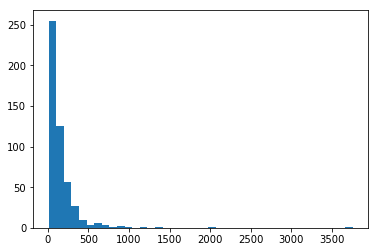

In [73]:
plt.hist(corpus.body.map(lambda b: len(b)).sort_values(), bins=40);

In [143]:
tok = nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)
stop = set(nltk.corpus.stopwords.words('english'))
stop.add("deleted")
stop.add("removed")
def tokens(body):
    return [w.lower() for w in tok.tokenize(body) 
            if (not w in string.punctuation) 
            and (not "/" in w) and len(w) > 1
            and not w in stop]

In [144]:
corpus["tokens"] = corpus.body.map(tokens)
frequency  = defaultdict(int)
for text in corpus.tokens:
    for token in text:
        frequency[token] += 1

In [145]:
corpus["tokens"] = corpus.tokens.apply(
    lambda text: [token for token in text if frequency[token] > 1])

In [147]:
dictornary = corpora.Dictionary(corpus.tokens)
dictornary.save(str(Path("data") / (submission.id + '.dict')))

In [148]:
corpus["bow"] = corpus.tokens.map(dictornary.doc2bow)

In [151]:
model = models.LdaModel(corpus.bow, id2word=dictornary, num_topics=10)

In [159]:
corpus['topics'] = model[corpus.bow]

In [193]:
def get_color(topics):
    #TODO: choose best
    c, p = max(topics,key=lambda t: t[1])
    return int(c), p


# df = pd.DataFrame.from_records(corpus.topics.map(get_color))
# df.pivot(index=0,columns=1,values=2)
corpus[["color", "percent"]] = corpus.topics.map(get_color).apply(pd.Series)
corpus = corpus.set_index("id")
corpus.head()

,body,tokens,bow,topics,color,percent
id,,,,,,
cxkqnwq,Where the shooting is:\n\n>*Inland Regional Ce...,"[where, shooting, inland, regional, center, em...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(4, 0.930759467837)]",4.0,0.930759
cxkup1s,"What amazes me about situations like this, is ...","[what, situations, like, many, people, call, t...","[(12, 1), (13, 1), (14, 1), (15, 1), (16, 2), ...","[(0, 0.244569171425), (1, 0.723422975794)]",1.0,0.723423
cxkwqik,"""Suspicious male in dark clothing under freewa...","[suspicious, male, dark, clothing, freeway, so...","[(14, 1), (34, 1), (35, 1), (36, 1), (37, 1), ...","[(1, 0.918172064209)]",1.0,0.918172
cxkt934,I have an autistic son and we visit this medic...,"[autistic, son, visit, medical, center, it's, ...","[(4, 1), (8, 1), (9, 1), (42, 1), (43, 1), (44...","[(6, 0.93075880166)]",6.0,0.930759
cxkrqxu,Department of Homeland Security aircraft circl...,"[department, security, aircraft, circling, sce...","[(51, 1), (52, 1), (53, 2), (54, 2), (55, 1), ...","[(7, 0.939994821004)]",7.0,0.939995


## Export

In [206]:
def traverse(children, visit):
    for child in children:
        visit(child)
        if "children" in child:
            traverse(child["children"],visit)
def set_topic_info(child):
    child["color"] = int(corpus.loc[child["id"]].color)
    child["percent"] = corpus.loc[child["id"]].percent
traverse(comment_data,set_topic_info)


In [207]:

submission_data = {
                    'id': submission.fullname,
                    'title': submission.title,
                    'created_utc': submission.created_utc,
                    'author_name' : submission.author.name,
                    'children': [],
                    'parent_id': ""
                  }
submission_data['children'] = comment_data
json.dump(submission_data, open('data/test_submission.json', mode='w'), indent=True)

Fazit: Eher nicht. Zu wenig Text. Themen als Farbe waren nicht hilfreich in der Visualisierung.

## BigQueryJSON Datensatz?

In [23]:
from path import Path
def fullname(jsonobj):
    jsonobj["id"] = "t1_" + jsonobj["id"]
    return jsonobj
for file in ["data/results-20170502-230026.json"]:
    with open(file) as bfile:
        data = [fullname(json.loads(line)) for line in bfile.readlines()]
    with open("data/data.json", mode='w') as jfile:
        data.append(submission_data)
        json.dump(data, jfile)

In [30]:
parents = set([c['parent_id'] for c in data])


In [31]:
len([c for c in data if c['parent_id'] in parents])

2001

In [33]:
data[:5]

[{'created_utc': '1449084244',
  'id': 't1_cxkpih0',
  'parent_id': 't3_3v6iq7',
  'score': '6'},
 {'created_utc': '1449084454',
  'id': 't1_cxkpo3w',
  'parent_id': 't3_3v6iq7',
  'score': '-34'},
 {'created_utc': '1449084459',
  'id': 't1_cxkpo9n',
  'parent_id': 't3_3v6iq7',
  'score': '3'},
 {'created_utc': '1449084528',
  'id': 't1_cxkpq2r',
  'parent_id': 't3_3v6iq7',
  'score': '-2'},
 {'created_utc': '1449084608',
  'id': 't1_cxkps5t',
  'parent_id': 't1_cxkpo3w',
  'score': '-6'}]

In [34]:
import pandas as pd

In [35]:
hndata = pd.read_csv("data/hn-results-20170503-113146.csv", encoding="utf8")
hndata.head()

,id,by,author,time,time_ts,text,parent,deleted,dead,ranking
0,15,sama,sama,1160423461,1.160423e+09,&#34;the rising star of venture capital&#34; -...,1,NaN,NaN,1
1,82729,vice,vice,1195735854,1.195736e+09,I'm nX 1 too<p>;)\n,1,NaN,True,4
2,487171,jacquesm,jacquesm,1235046083,1.235046e+09,"So, just to see how hard it is to make the lon...",1,NaN,NaN,0
3,234509,kleevr,kleevr,1215030588,1.215031e+09,sequential numbering\n I must be bored,1,NaN,NaN,2
4,454410,Arrington,Arrington,1233174694,1.233175e+09,This is why we can't have nice things.,1,NaN,True,3


Fazit: Offline Datensatz ist leichter zu bearbeiten.